In [ ]:
!pip install pykan

### CNNS WITH KAN

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchsummary import summary
from PIL import Image
import math
import scipy.io as sio
import numpy as np
from kan import *
import torchvision.transforms as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
import time

Paths

In [ ]:
data_path = '/content/drive/Shareddrives/DeepLearning/FinalProject/data/'
results_path = '/content/drive/Shareddrives/DeepLearning/FinalProject/results/results_CNN_KAN/'

Efficient KAN class from https://github.com/Blealtan/efficient-kan/blob/f39e5146af34299ad3a581d2106eb667ba0fa6fa/src/efficient_kan/kan.py#L6

# Create datasets

## Initialize SVHN dataset

In [ ]:
## Create SVHN database
#Making native class loader
class SVHN(torch.utils.data.Dataset):
    # Initialization method for the dataset
    def __init__(self,dataDir = data_path+'/svhn/train_32x32.mat',transform = None):
        mat_loaded = sio.loadmat(dataDir)
        self.data = mat_loaded['X']
        self.labels = mat_loaded['y'].squeeze()
        self.labels -= self.labels.min()
        self.transform = transform
     # What to do to load a single item in the dataset ( read image and label)
    def __getitem__(self, index):
        data = self.data[:,:,:,index]
        lbl = self.labels[index]

        data = Image.fromarray(data)
        # Apply a trasnformaiton to the image if it is indicated in the initalizer
        if self.transform is not None :
            data = self.transform(data)

        # return the image and the label
        return data,lbl

        pass

    # Return the number of images
    def __len__(self):
        return self.data.shape[3]

# Create train data loader
tr_SVHN = tf.Compose([
    tf.Resize((32, 32)),
    tf.ToTensor(),
    tf.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
SVHNTrain = SVHN(data_path+'/svhn/train_32x32.mat',tr_SVHN)
svhn_train_loader = torch.utils.data.DataLoader(dataset=SVHNTrain,
                                               batch_size=256,
                                               shuffle=True)
# Show results for all the trained models
SVHNTest = SVHN(data_path+'/svhn/test_32x32.mat',tr_SVHN)
svhn_test_loader = torch.utils.data.DataLoader(dataset=SVHNTest,
                                               batch_size=256,
                                               shuffle=True)

### Initialize MNIST

In [ ]:
#Making native class loader
class MNIST(torch.utils.data.Dataset):

    def __init__(self,dataDir = data_path+'/mnist/train.pt',transform = None):
        self.data, self.labels = torch.load(dataDir)
        self.transform = transform

    def __getitem__(self, index):
        data = self.data[index]
        lbl = self.labels[index]

        data = Image.fromarray(data.numpy(), mode='L')

        if self.transform is not None :
            data = self.transform(data)

        return data,lbl

        pass
    def __len__(self):
        return len(self.data)



tr_MNIST = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean = [.5], std = [.5])
        ])
MNISTTrain = MNIST(data_path+'/mnist/train.pt',tr_MNIST)
mnist_train_loader = torch.utils.data.DataLoader(dataset=MNISTTrain,
                                               batch_size=256,
                                               shuffle=True)
# Load test dataset
MNISTTest = MNIST(data_path+'/mnist/test.pt',tr_MNIST)
mnist_test_loader = torch.utils.data.DataLoader(dataset=MNISTTest,
                                            batch_size=256,
                                            shuffle=True)

# Define architectures

### KAN CNN

KAN linear layer block from: https://github.com/Blealtan/efficient-kan/blob/f39e5146af34299ad3a581d2106eb667ba0fa6fa/src/efficient_kan/kan.py#L6

In [ ]:
# Efficient KAN layer implementation
class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = self.grid
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )
        B = y.transpose(0, 1)
        solution = torch.linalg.lstsq(
            A, B
        ).solution
        result = solution.permute(
            2, 0, 1
        )

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        return base_output + spline_output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)
        splines = splines.permute(1, 0, 2)
        orig_coeff = self.scaled_spline_weight
        orig_coeff = orig_coeff.permute(1, 2, 0)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )

        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )




SVHN

In [ ]:
class KAN_CNN_SVHN(nn.Module):
    def __init__(self, num_classes=10):
        super(KAN_CNN_SVHN, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, padding=2)  # Input: 3 channels (RGB), Output: 16 channels, Filter size: 5x5
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # Input: 16 channels, Output: 32 channels, Filter size: 3x3

        self.kan_layer_1 = KANLinear(8 * 8 * 32, num_classes)  # Adjusted for 8x8 feature map
        #self.kan_layer_2 = KANLinear(50, num_classes)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.conv2(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = out.reshape(out.size(0), -1)  # Reshape: 128,32,8,8 -> 128,8*8*32

        out = self.kan_layer_1(out)
        #out = self.kan_layer_2(out)

        return out

MNIST

In [ ]:
'''
class KAN_CNN_MNIST(nn.Module):
    def __init__(self, num_classes):
        super(KAN_CNN_MNIST, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2)
        self.kan1 = KANLinear(64 * 7 * 7, 256)
        self.kan2 = KANLinear(256, num_classes)

    def forward(self, x):
        x = F.selu(self.conv1(x))
        x = self.pool1(x)
        x = F.selu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.kan1(x)
        x = self.kan2(x)
        return x

class KAN_CNN_MNIST(nn.Module):
    def __init__(self, num_classes=10):
        super(KAN_CNN_MNIST, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2)
        self.kan1 = KANLinear(64 * 7 * 7, 256)
        self.kan2 = KANLinear(256, num_classes)

    def forward(self, x):
        x = F.selu(self.conv1(x))
        x = self.pool1(x)
        x = F.selu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.kan1(x)
        x = self.kan2(x)
        return x
'''
class KAN_CNN_MNIST(nn.Module):
    def __init__(self, num_classes=10):

        super(KAN_CNN_MNIST, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=5,  padding=2)
        #input : 1 channel, output 16 channel, filter size : 5x5

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3,  padding=1)
        #input : 1 channel, output 16 channel, filter size : 3x3

        self.kan1 = KANLinear(64 * 7 * 7, num_classes)
        #self.kan2 = KANLinear(256, num_classes)

        self.maxpool= nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

    def forward(self, x):

        out = self.conv1(x)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.conv2(out)
        out = self.relu(out)
        out = self.maxpool(out)


        out = out.reshape(out.size(0), -1) #128,32,28,28 -> 128,28*28*32

        out = self.kan1(out)
        #out = self.kan2(out)
        return out

## Standard CNN

SVHN

In [ ]:
class CNN_SVHN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN_SVHN, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, padding=2)  # Input: 3 channels (RGB), Output: 16 channels, Filter size: 5x5
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # Input: 16 channels, Output: 32 channels, Filter size: 3x3

        self.fc = nn.Linear(8 * 8 * 32, num_classes)  # Adjusted for 8x8 feature map

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.conv2(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = out.reshape(out.size(0), -1)  # Reshape: 128,32,8,8 -> 128,8*8*32

        out = self.fc(out)  # No need for sigmoid or other activation functions at the end

        return out


MNIST

In [ ]:
# Define an standard CNN -> Two conv. blocks and linear layer
class CNN_MNIST(nn.Module):
    def __init__(self, num_classes=10):

        super(CNN_MNIST, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size=5,  padding=2)
        #input : 1 channel, output 16 channel, filter size : 5x5

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3,  padding=1)
        #input : 1 channel, output 16 channel, filter size : 3x3

        self.fc = nn.Linear(7*7*32, num_classes)

        self.maxpool= nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

    def forward(self, x):

        out = self.conv1(x)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.conv2(out)
        out = self.relu(out)
        out = self.maxpool(out)


        out = out.reshape(out.size(0), -1) #128,32,28,28 -> 128,28*28*32

        out = self.fc(out) # we don't need sigmoid or other activation function at the end beacuse we will use nn.CrossEntropyLoss() (check documentation to understand why)

        return out

In [ ]:
# Compute model paramters
def compute_model_params(model):
  params = 0
  for p in model.parameters():
    params+= p.numel()
  return params

### Define train and test functions

In [ ]:
# Train function
def train(CNN, train_loader, optimizer, num_epochs=5, model_name='model.ckpt', device='cpu'):
    CNN.train() # Set the model in train mode
    total_step = len(train_loader)
    losses_list = []
    criterion = nn.CrossEntropyLoss()
    # Iterate over epochs
    for epoch in range(num_epochs):
        # Iterate the dataset
        loss_avg = 0
        nBatches = 0
        for i, (images, labels) in enumerate(train_loader):
            # Get batch of samples and labels
            images = images.to(device)
            labels = labels.type(torch.LongTensor).to(device)

            # Forward pass
            outputs = CNN(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_avg += loss.cpu().item()
            nBatches+=1
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                       .format(epoch+1, num_epochs, i+1, total_step, loss_avg / nBatches))
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                       .format(epoch+1, num_epochs, i+1, total_step, loss_avg / nBatches))
        losses_list.append(loss_avg / nBatches)
        torch.save(CNN.state_dict(), results_path+ '/' + model_name)

    return losses_list

# Test function with confusion matrix calculation
def test(CNN, test_loader, device):
    CNN.eval()
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            # get network predictions
            outputs = CNN(images)

            # get predicted class
            _, predicted = torch.max(outputs.data, 1)

            # compare with the ground-truth
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # store labels and predictions for the confusion matrix
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

        # Calculate accuracy
        accuracy = 100 * correct / total

        # Calculate confusion matrix
        conf_matrix = confusion_matrix(all_labels, all_predictions)

        return accuracy, conf_matrix

def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

Train and testnetworks

In [ ]:
def train_net(model, train_loader, optimizer, name, epochs=10 ):
    n_params = compute_model_params(model)
    print(f"{name} parameters: " + str(n_params))
    model.cuda()
    #Train


    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    st = time.time()
    losses_list = train(model, train_loader, optimizer, num_epochs=epochs, model_name=f'{name}.ckpt', device=device)
    et = time.time()

    # Build graph
    plt.plot(losses_list, label='Training Losses')
    plt.title('Losses during training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    print(f'Training time: {et - st} seconds')
    return losses_list, (et-st)


In [ ]:
def test_net(my_net, test_loader, name):
    # Load the model and test it
    class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    my_net.load_state_dict(torch.load(results_path + f'/{name}.ckpt'))
    my_net.cuda()
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    acc, conf_mat = test(my_net, test_loader, device)
    print(f'Accuracy {name}: ' + str(acc))

    # Plot confusion matrix
    plot_confusion_matrix(conf_mat, class_names)

### Train and test networks

Create all networks

In [ ]:
train_KAN_CNN_SVHN = KAN_CNN_SVHN()
train_KAN_CNN_MNIST = KAN_CNN_MNIST()
train_CNN_SVHN = CNN_SVHN()
train_CNN_MNIST = CNN_MNIST()

test_KAN_CNN_SVHN = KAN_CNN_SVHN()
test_KAN_CNN_MNIST = KAN_CNN_MNIST()
test_CNN_SVHN = CNN_SVHN()
test_CNN_MNIST = CNN_MNIST()

Define optimizers to use

In [ ]:
# SGD
optimizer_SGD_KAN_CNN_SVHN = torch.optim.SGD(train_KAN_CNN_SVHN.parameters(),lr = .1, weight_decay=1e-5, momentum=0.9)
optimizer_SGD_KAN_CNN_MNIST = torch.optim.SGD(train_KAN_CNN_MNIST.parameters(), lr=0.1, weight_decay=1e-5, momentum=0.9)
optimizer_SGD_CNN_SVHN = torch.optim.SGD(train_CNN_SVHN.parameters(), lr=0.1, weight_decay=1e-5, momentum=0.9)
optimizer_SGD_CNN_MNIST = torch.optim.SGD(train_CNN_MNIST.parameters(), lr=0.1, weight_decay=1e-5, momentum=0.9)

# Adam
optimizer_Adam_KAN_CNN_MNIST = optim.AdamW(train_KAN_CNN_MNIST.parameters(), lr=0.001, weight_decay=1e-3)
optimizer_Adam_KAN_CNN_SVHN = optim.AdamW(train_KAN_CNN_MNIST.parameters(), lr=0.12, weight_decay=1e-3)


Train networks

In [ ]:
# Create parameter lists
train_models = [train_KAN_CNN_SVHN, train_KAN_CNN_MNIST, train_CNN_SVHN, train_CNN_MNIST]
train_loaders = [svhn_train_loader, mnist_train_loader, svhn_train_loader, mnist_train_loader]
optimizers = [optimizer_SGD_KAN_CNN_SVHN, optimizer_SGD_KAN_CNN_MNIST, optimizer_SGD_CNN_SVHN, optimizer_SGD_CNN_MNIST]
names = ["KAN_CNN_SVHN", "KAN_CNN_MNIST", "CNN_SVHN", "CNN_MNIST"]
epochs = [5, 5, 5, 5]

test_models = [test_KAN_CNN_SVHN, test_KAN_CNN_MNIST, test_CNN_SVHN, test_CNN_MNIST]
test_loaders = [svhn_test_loader, mnist_test_loader, svhn_test_loader, mnist_test_loader]

# Initialize outputs
losses = []
training_times = []

KAN_CNN_SVHN parameters: 210656
Epoch [1/5], Step [100/287], Loss: 1.6912
Epoch [1/5], Step [200/287], Loss: 1.1810
Epoch [1/5], Step [287/287], Loss: 0.9961
Epoch [2/5], Step [100/287], Loss: 0.5142
Epoch [2/5], Step [200/287], Loss: 0.5113
Epoch [2/5], Step [287/287], Loss: 0.4967
Epoch [3/5], Step [100/287], Loss: 0.4332
Epoch [3/5], Step [200/287], Loss: 0.4291
Epoch [3/5], Step [287/287], Loss: 0.4299
Epoch [4/5], Step [100/287], Loss: 0.3869
Epoch [4/5], Step [200/287], Loss: 0.3956
Epoch [4/5], Step [287/287], Loss: 0.3916
Epoch [5/5], Step [100/287], Loss: 0.3744
Epoch [5/5], Step [200/287], Loss: 0.3809
Epoch [5/5], Step [287/287], Loss: 0.3785


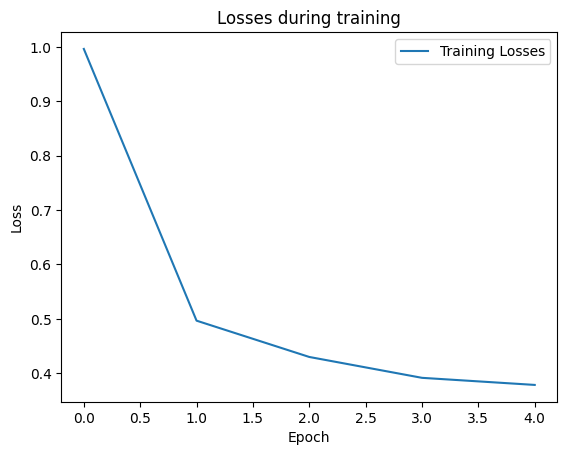

Training time: 149.82080793380737 seconds
Training time was: 149.82080793380737
Accuracy KAN_CNN_SVHN: 84.96081745543945


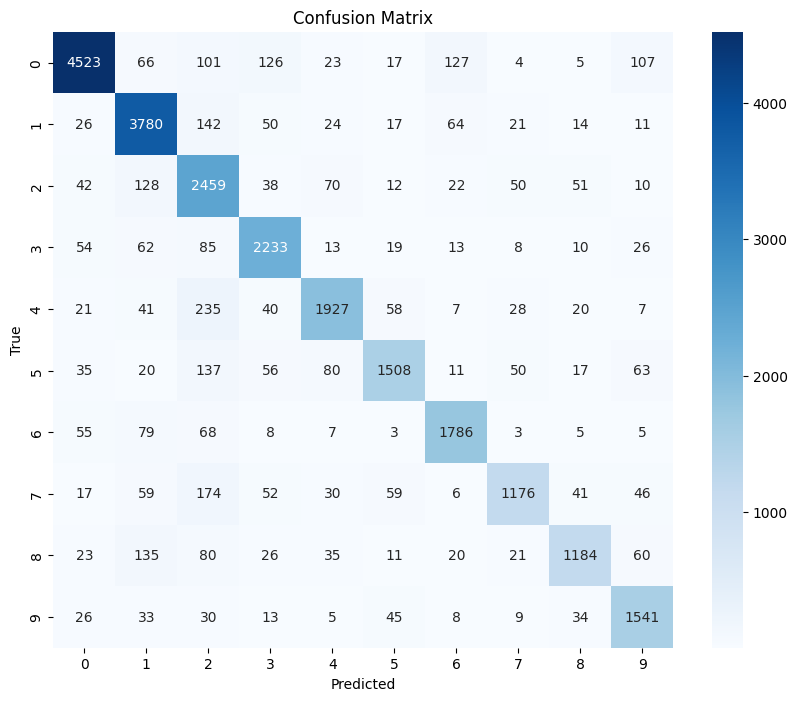

KAN_CNN_MNIST parameters: 332928
Epoch [1/5], Step [100/235], Loss: 0.4836
Epoch [1/5], Step [200/235], Loss: 0.2817
Epoch [1/5], Step [235/235], Loss: 0.2501
Epoch [2/5], Step [100/235], Loss: 0.0538
Epoch [2/5], Step [200/235], Loss: 0.0522
Epoch [2/5], Step [235/235], Loss: 0.0514
Epoch [3/5], Step [100/235], Loss: 0.0434
Epoch [3/5], Step [200/235], Loss: 0.0397
Epoch [3/5], Step [235/235], Loss: 0.0392
Epoch [4/5], Step [100/235], Loss: 0.0316
Epoch [4/5], Step [200/235], Loss: 0.0312
Epoch [4/5], Step [235/235], Loss: 0.0306
Epoch [5/5], Step [100/235], Loss: 0.0250
Epoch [5/5], Step [200/235], Loss: 0.0273
Epoch [5/5], Step [235/235], Loss: 0.0272


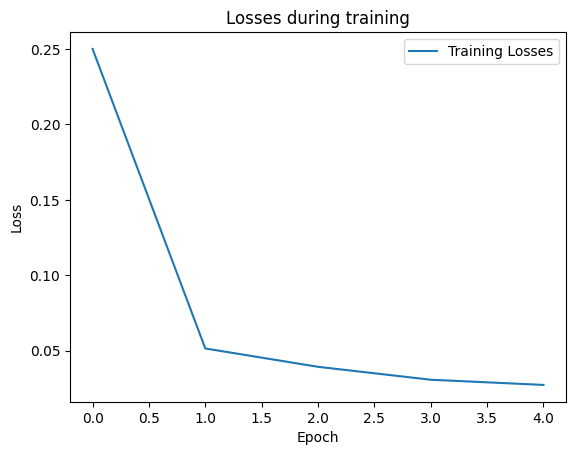

Training time: 108.87103819847107 seconds
Training time was: 108.87103819847107
Accuracy KAN_CNN_MNIST: 99.08


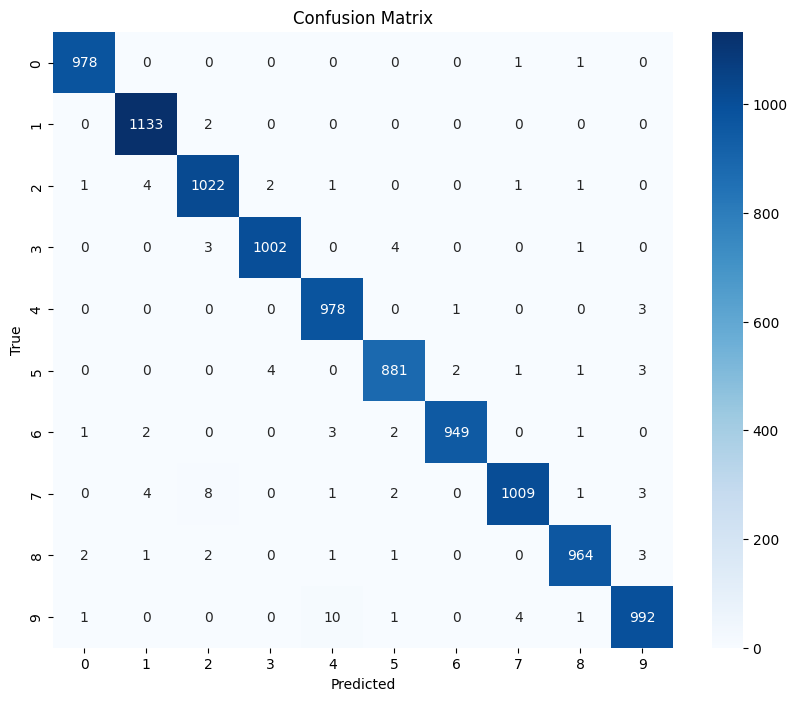

CNN_SVHN parameters: 26346
Epoch [1/5], Step [100/287], Loss: 1.4267
Epoch [1/5], Step [200/287], Loss: 1.0276
Epoch [1/5], Step [287/287], Loss: 0.8870
Epoch [2/5], Step [100/287], Loss: 0.5347
Epoch [2/5], Step [200/287], Loss: 0.5101
Epoch [2/5], Step [287/287], Loss: 0.5009
Epoch [3/5], Step [100/287], Loss: 0.4558
Epoch [3/5], Step [200/287], Loss: 0.4480
Epoch [3/5], Step [287/287], Loss: 0.4508
Epoch [4/5], Step [100/287], Loss: 0.4159
Epoch [4/5], Step [200/287], Loss: 0.4316
Epoch [4/5], Step [287/287], Loss: 0.4324
Epoch [5/5], Step [100/287], Loss: 0.4263
Epoch [5/5], Step [200/287], Loss: 0.4160
Epoch [5/5], Step [287/287], Loss: 0.4159


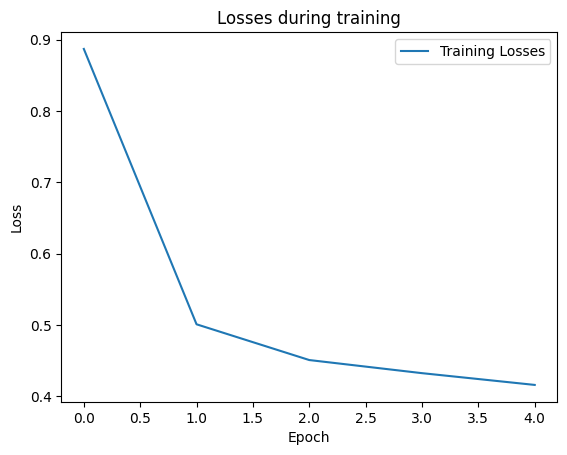

Training time: 117.45222115516663 seconds
Training time was: 117.45222115516663
Accuracy CNN_SVHN: 83.34357713583282


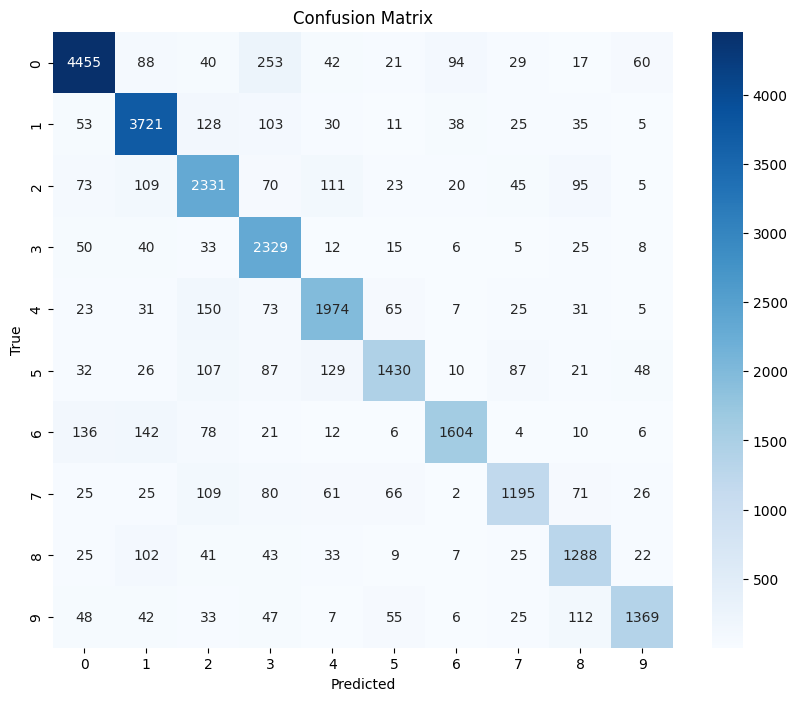

CNN_MNIST parameters: 20746
Epoch [1/5], Step [100/235], Loss: 3.0684
Epoch [1/5], Step [200/235], Loss: 2.1520
Epoch [1/5], Step [235/235], Loss: 1.9425
Epoch [2/5], Step [100/235], Loss: 0.5131
Epoch [2/5], Step [200/235], Loss: 0.4551
Epoch [2/5], Step [235/235], Loss: 0.4428
Epoch [3/5], Step [100/235], Loss: 0.3717
Epoch [3/5], Step [200/235], Loss: 0.3439
Epoch [3/5], Step [235/235], Loss: 0.3365
Epoch [4/5], Step [100/235], Loss: 0.2544
Epoch [4/5], Step [200/235], Loss: 0.2378
Epoch [4/5], Step [235/235], Loss: 0.2350
Epoch [5/5], Step [100/235], Loss: 0.2058
Epoch [5/5], Step [200/235], Loss: 0.1965
Epoch [5/5], Step [235/235], Loss: 0.1930


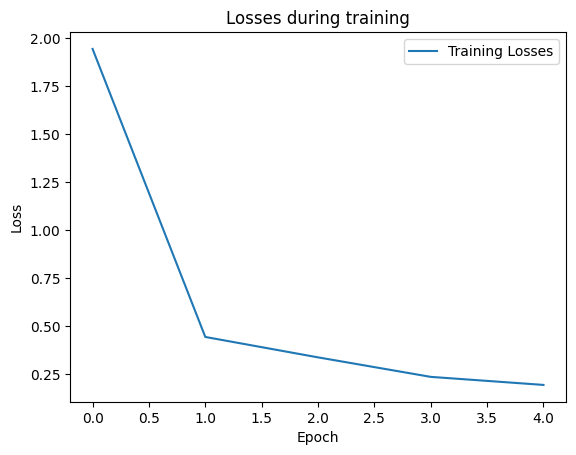

Training time: 70.84099650382996 seconds
Training time was: 70.84099650382996
Accuracy CNN_MNIST: 94.7


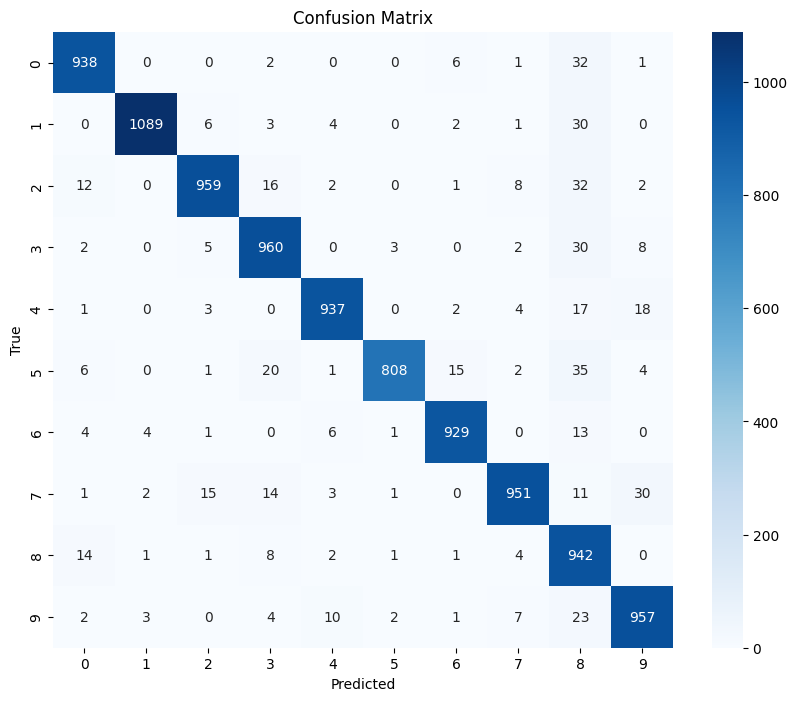

In [ ]:
# Train  and test them
for i in range(len(train_models)):

#for i in [3]:
    loss, train_time = train_net(train_models[i], train_loaders[i], optimizers[i], names[i], epochs[i])
    print(f"Training time was: {train_time}")
    losses.append(loss)
    training_times.append(train_time)
    test_net(test_models[i], test_loaders[i], names[i])

#test_net(test_models[1], test_loaders[1], names[1])